# CDC - Chetty's Income Mobility Measures
## EDA and Plots

In [193]:
# load libraries
library(sdazar)
library(INLA)
library(brinla)

library(ggplot2)
library(patchwork)
library(forcats)

library(usmap)
library(USAboundaries)
library(maptools)
library(ggthemes)
library(spdep)
library(sp)
library(sf)

# set plot options
options(repr.plot.width = 7, repr.plot.height = 4) # plot options

In [194]:
df = readRDS('../data/cdc_chetty.rds')

In [195]:
mob = df[, lapply(.SD, first), 
         by=.(fips, county, county_name, stateabbrv)]

In [196]:
# remove crime rate
variables = c('z_relative_mob', 'z_absolute_mob', 'z_gini',
              'z_medicare_expenses', 'log_unemployment', 'z_uninsured',
              'log_pct_black', 'log_pct_hispanic')

In [197]:
print(countmis(df))

         z_exercise           z_obesity           z_smoking      z_relative_mob 
              0.219               0.218               0.217               0.071 
     z_absolute_mob      log_crime_rate              z_gini z_medicare_expenses 
              0.071               0.057               0.024               0.002 
   log_unemployment         z_uninsured       log_pct_black    log_pct_hispanic 
              0.001               0.001               0.000               0.000 


In [198]:
df = df[complete.cases(df[, variables, with=FALSE])]

In [199]:
print(countmis(df))

    z_exercise      z_obesity      z_smoking log_crime_rate 
         0.167          0.165          0.164          0.059 


In [200]:
mob = df[, .(z_relative_mob=first(z_relative_mob), 
             z_absolute_mob=first(z_relative_mob)), 
         by=.(fips, county, county_name, stateabbrv)]

## Define county info for spatial models

In [201]:
# get counties, US 2000
counties = us_counties("2000-07-01")

In [202]:
class(counties)

[1] "sf"         "data.frame"

In [203]:
length(unique(mob$fips)) / length(counties$fips) # 91%

[1] 0.9127666

In [204]:
counties = counties[counties$fips %in% unique(mob$fips),]

In [205]:
all(as.character(counties$fips) %in% unique(mob$fips))

[1] TRUE

In [206]:
all(unique(mob$fips) %in% as.character(counties$fips))

[1] TRUE

In [207]:
unique(mob$fips)[!unique(mob$fips) %in% counties$fips] # nothing

character(0)

In [208]:
ordered_fips = as.character(unique(counties$fips))

In [209]:
length(ordered_fips)

[1] 2867

In [211]:
# order data based on counties
mob = mob[order(match(fips, ordered_fips))]

In [212]:
data[, county_i := .GRP, by = fips]
data[, state_i := .GRP, by = state]

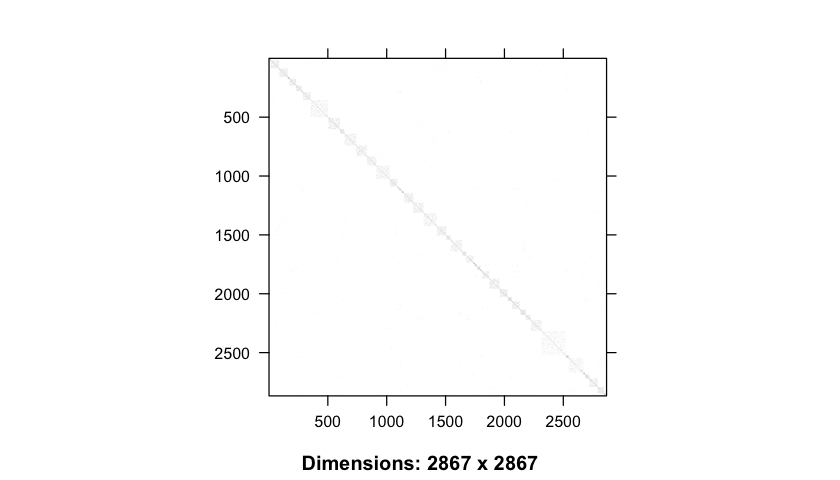

In [213]:
counties.sp = as(counties, "Spatial")
temp = poly2nb(counties.sp)
nb2INLA("counties.graph", temp)
county.adj = "counties.graph"
H = inla.read.graph(filename = county.adj)
image(inla.graph2matrix(H), xlab="",ylab="")

## County coverage plot

In [148]:
library(usmap)

In [155]:
c = data.table(countypop)

In [156]:
c = merge(c, mob[, .(fips, z_relative_mob)], by='fips', all.x=TRUE)

In [157]:
c[, coverage := ifelse(is.na(z_relative_mob), 0, 1)]

In [158]:
summary(c$coverage)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9118  1.0000  1.0000 

In [159]:
table(c[coverage==0, abbr])


AK CA CO FL GA HI ID IL KS KY MI MO MS MT NC ND NE NM NV OK OR SD TN TX UT VA 
13  2 17  2 13  1  7  2 26  5  1  4  1 19  1 19 32  4  5  6  3 24  3 49  4  8 
WA WI WY 
 3  1  2 

In [ ]:
savepdf('coverage_county')
usmap::plot_usmap(data = c, values = "coverage", regions = "counties", lines='black') + 
#   labs(title = County Coverage Income Mobility Data", subtitle = "91% of counties", 
#       caption='') + 
  theme(legend.position="none") + 
  scale_fill_continuous(
    low = "white", high = "#fdbb84")
dev.off()

In [189]:
dim(mob)

## Descriptive table